In [1]:
"""
Author: Lai ZhonPoa
"""
# Bryans individual is not limited to BryanIndividual.ipynb
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from UtilsNeo4J import DataBaseHandler
from UtilsRedis import Redis_Utilities

from GlobalSparkSession import GlobalSparkSession
from pyspark.sql.functions import explode, col
spark = GlobalSparkSession.get_instance()

# Setup Neo4j driver and Redis client 22/12/2024
neo4j_uri = "neo4j+s://75fb82ba.databases.neo4j.io"
neo4j_user = "neo4j"
neo4j_password = "E2znDHtP7x2Hs0B5_BM1tnglu6fTkM5YPTX18DkubIk" # Replace with your actual password
redis_utils = Redis_Utilities()

db_handler = DataBaseHandler(neo4j_uri, neo4j_user, neo4j_password, redis_utils)

# Get the total number of unique entries in the lexicon
total_unique_entries = db_handler.get_total_unique_entries()
print(f"Total number of unique entries: {total_unique_entries}")

24/12/22 18:59:53 WARN Utils: Your hostname, R2D3. resolves to a loopback address: 127.0.1.1; using 172.28.168.56 instead (on interface eth0)
24/12/22 18:59:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/22 18:59:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/22 18:59:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/22 18:59:56 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/22 18:59:56 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Total number of unique entries: 10104


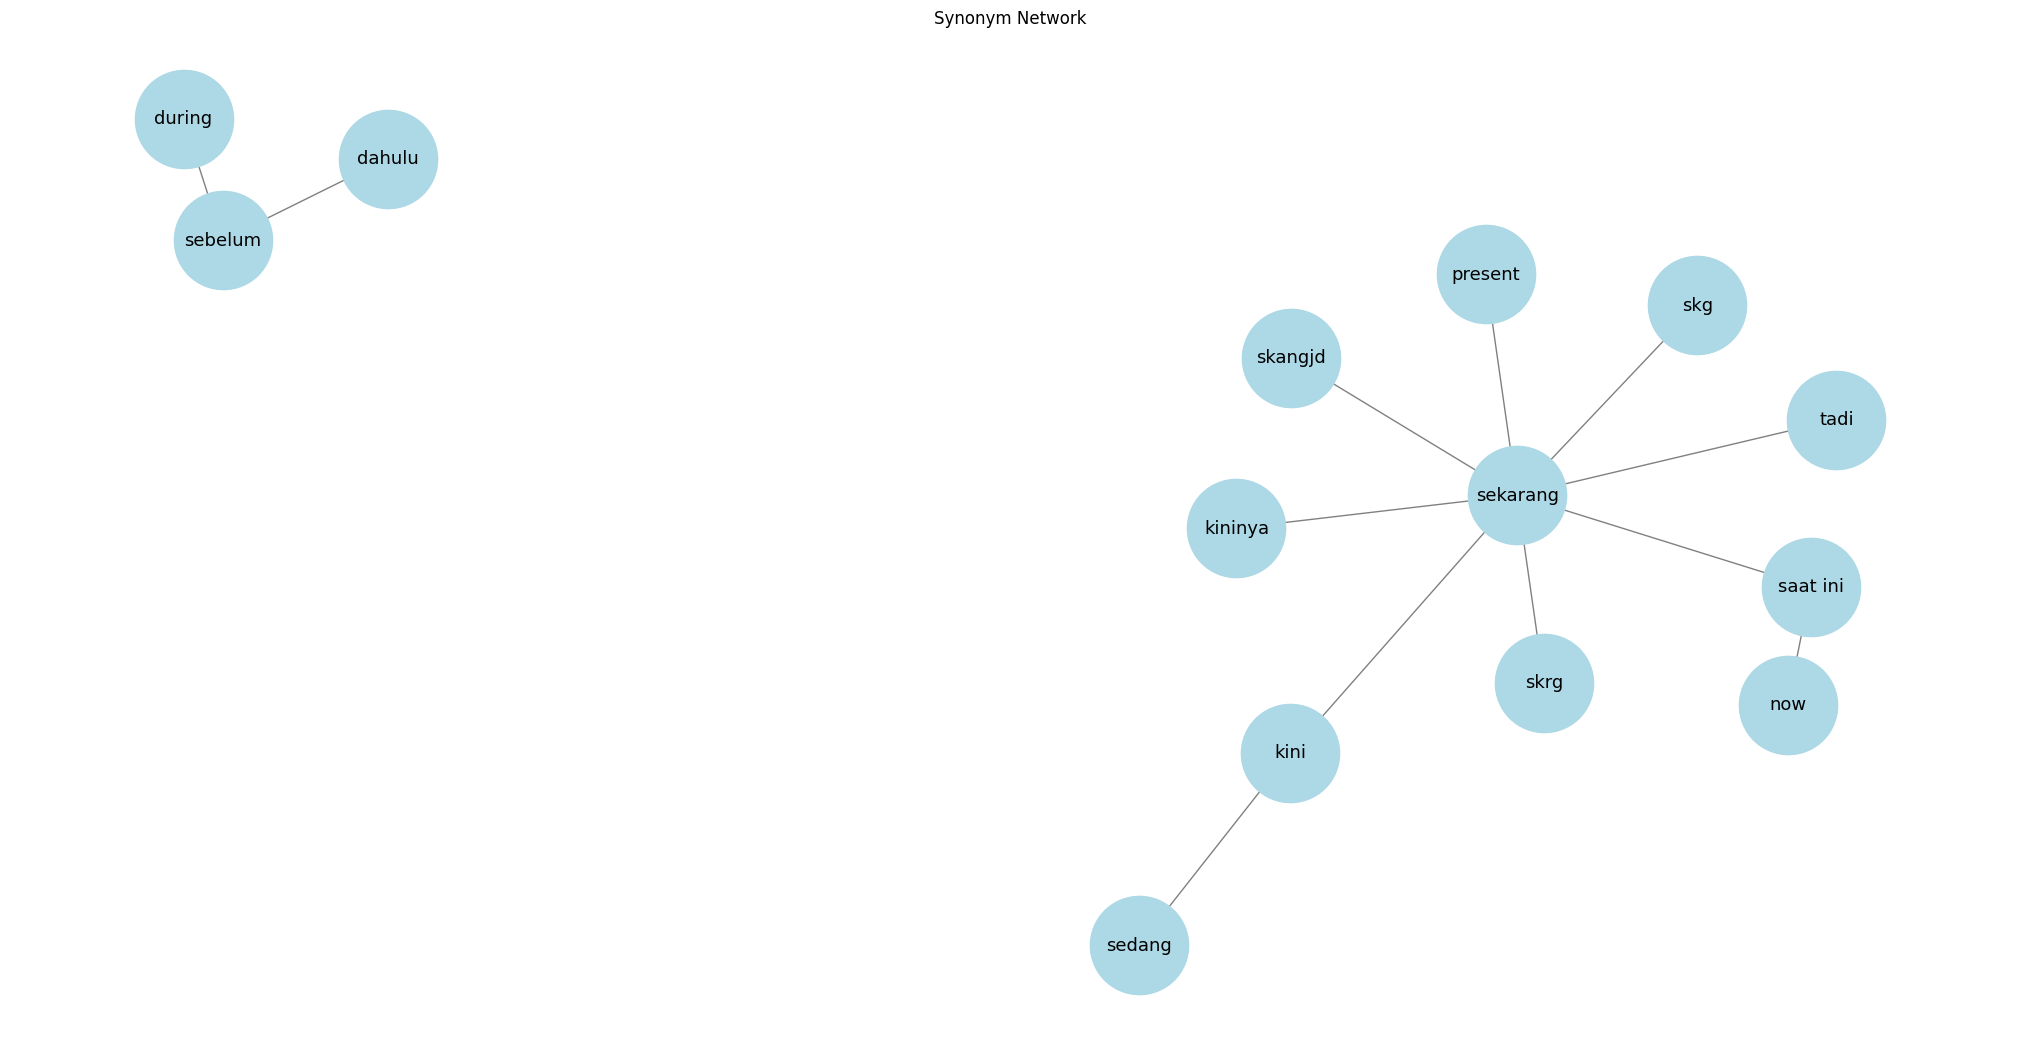

Theme 0: skg, tadi, sekarang, skrg, kininya, skangjd, present
Theme 1: during, sebelum, dahulu
Theme 2: saat ini, now
Theme 3: sedang, kini


In [2]:
# Graph Visualization Functions
def fetch_synonyms(tx, limit=25):
    query = f"""
    MATCH (w:Word)-[:SYNONYM]-(s:Word)
    RETURN w.word AS word, collect(DISTINCT s.word) AS synonyms
    LIMIT {limit}
    """
    result = tx.run(query)
    return result.values()

def create_synonym_network_pyspark(spark, db_handler, limit=20):
    with db_handler.neo4j_driver.session() as session:
        synonyms = session.execute_read(fetch_synonyms, limit)
    
    # Convert to DataFrame
    synonyms_df = spark.createDataFrame(synonyms, ["word", "synonyms"])
    
    # Explode the synonyms list into individual rows
    exploded_df = synonyms_df.withColumn("synonym", explode(col("synonyms"))).select("word", "synonym")
    
    # Use toLocalIterator to avoid memory issues
    edges = [(row.word, row.synonym) for row in exploded_df.toLocalIterator()]
    
    # Create a graph
    G = nx.Graph()
    G.add_edges_from(edges)
    
    return G

def visualize_network(G):
    pos = nx.spring_layout(G, k=0.55)
    plt.figure(figsize=(20, 10))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=5000, font_size=13)
    plt.title("Synonym Network")
    plt.show()

def identify_clusters(G):
    clusters = nx.community.greedy_modularity_communities(G)
    themes = {i: list(cluster) for i, cluster in enumerate(clusters)}
    return themes

G = create_synonym_network_pyspark(spark, db_handler, limit=10) 
visualize_network(G)

themes = identify_clusters(G)
for theme_id, words in themes.items():
    print(f"Theme {theme_id}: {', '.join(words)}")

In [3]:
from UtilsRedis import Redis_Utilities
import redis
def get_word_data(word_to_search):
    redis_utils = Redis_Utilities()
    
    sentiment_value = redis_utils.get_sentiment(word_to_search)
    word_count = redis_utils.get_word_frequency(word_to_search)
    
    synonyms = db_handler.get_synonyms(word_to_search)
    antonyms = db_handler.get_antonyms(word_to_search)
    
    
    print(f"Synonyms for '{word_to_search}': {', '.join(synonyms)}")
    print(f"Antonyms for '{word_to_search}': {', '.join(antonyms)}")
    print(f"Sentiment for '{word_to_search}':", sentiment_value)
    print(f"Count for '{word_to_search}':", word_count)

get_word_data("sedih")
get_word_data("kerana")
get_word_data("sekarang")
get_word_data("hasil")

Synonyms for 'sedih': dukacita
Antonyms for 'sedih': gembira
Sentiment for 'sedih': {'sentiment': '-0.8'}
Count for 'sedih': 1
Synonyms for 'kerana': oleh sebab
Antonyms for 'kerana': walaupun
Sentiment for 'kerana': {'sentiment': '0.0'}
Count for 'kerana': 53
Synonyms for 'sekarang': saat ini
Antonyms for 'sekarang': dulu
Sentiment for 'sekarang': {'sentiment': '0.0'}
Count for 'sekarang': 14
Synonyms for 'hasil': pendapatan
Antonyms for 'hasil': kehilangan
Sentiment for 'hasil': {'sentiment': '0.7'}
Count for 'hasil': 6


In [4]:
from pyspark.sql import Row
from pyspark.sql.functions import col
from UtilsRedis import Redis_Utilities

def analyze_word_frequencies(spark, num_rows=10):
    """
    Analyze and display word frequencies.

    Args:
        num_rows (int): Number of rows to show in the preview and frequency lists.
    """
    # Initialize Redis client and retrieve all frequencies
    redis_client = Redis_Utilities()
    frequencies = redis_utils.get_all_word_frequencies()

    # Convert the dictionary to a PySpark DataFrame
    word_frequencies_list = [{"Cleaned_Word": word, "Frequency": int(freq)} for word, freq in frequencies.items()]
    word_frequencies_df = spark.createDataFrame(Row(**x) for x in word_frequencies_list)

    # Show the preview of word frequencies
    print(f"Preview of all word frequencies (first {num_rows} rows):")
    word_frequencies_df.show(num_rows)

    # Most common words
    most_common_words_df = word_frequencies_df.orderBy(col("Frequency").desc()).limit(num_rows)
    print("Most common words:")
    most_common_words_df.show()

    # Least common words
    least_common_words_df = word_frequencies_df.orderBy(col("Frequency").asc()).limit(num_rows)
    print("Least common words:")
    least_common_words_df.show()

    # Words used exactly once
    once_used_df = word_frequencies_df.filter(col("Frequency") == 1)
    once_used = [row["Cleaned_Word"] for row in once_used_df.collect()]
    print("\nWords used once:")
    print(", ".join(once_used))

# Call the function with the desired number of rows to display
analyze_word_frequencies(spark, num_rows=10)

Preview of all word frequencies (first 10 rows):


+--------------+---------+
|  Cleaned_Word|Frequency|
+--------------+---------+
|            te|        2|
|        differ|        2|
|  tembelangnya|        1|
|  berikutpanjb|        1|
|   menyebarkan|        1|
|           hak|        3|
|         press|        2|
|thamazightcode|        1|
|    kadangkala|        3|
|       berilah|        1|
+--------------+---------+
only showing top 10 rows

Most common words:


+------------+---------+
|Cleaned_Word|Frequency|
+------------+---------+
|         dan|     1363|
|      bahasa|     1103|
|        yang|      701|
|          di|      632|
|       dalam|      481|
|      dengan|      358|
|    masukkan|      320|
|       cawan|      228|
|         ini|      219|
|          gm|      212|
+------------+---------+

Least common words:
+---------------+---------+
|   Cleaned_Word|Frequency|
+---------------+---------+
|        ridhwan|        1|
|melayuindonesia|        1|
|         bacaan|        1|
|           tili|        1|
|       dicampur|        1|
|         keruan|        1|
|   terpulanglah|        1|
|      southeast|        1|
|    fillingkeju|        1|
|        greater|        1|
+---------------+---------+


Words used once:
tembelangnya, berikutpanjb, menyebarkan, thamazightcode, berilah, dirasmikan, what, mohon, book, meluassedikit, penganut, secukupnyasedikit, menyokong, pelabagai, gaelik, angaran, berkeluarga, bukharisebab, caridotmyna